Paper:
https://arxiv.org/pdf/1512.04150.pdf

GitHub:
https://github.com/jacobgil/keras-cam

In [1]:
import glob
import os, sys
import numpy as np

import cv2
import skimage
import matplotlib.pyplot as plt
from keras.preprocessing import image as kimage

%matplotlib inline
sys.path.insert(0,'..') # add parent directory to path

import keras
from keras.utils.np_utils import to_categorical
import h5py

from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras import backend as K
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator

from keras.models import *
from keras.callbacks import *
import keras.backend as K

from sklearn.model_selection import train_test_split

import utils
import core_models
import poet_file_manager

Using TensorFlow backend.


In [2]:
img_width = 224
img_size = (img_width, img_width)
img_shape = (img_width, img_width, 3)

In [3]:
train_ids, test_ids = utils.load_object('../train_ids.pkl'), utils.load_object('../test_ids.pkl')

In [4]:
def global_average_pooling(x):
    return K.mean(x, axis = (1, 2))

def global_average_pooling_shape(input_shape):
    return input_shape[2:4]

def get_model(out_classes, img_shape, mode='vgg'):
    
    if mode=='vgg':
        model = core_models.VGG16_convolutions(img_shape=img_shape)
        model = load_model_weights(model, "./vgg.h5")

    #     model = resnet()
        for layer in model.layers[:]:
            layer.trainable = False
    
    if mode=='other':
        model = core_models.other_model(img_shape)
        
    # Rename last conv layer to later access it for CAM
    model.layers[-1].name = 'last_conv'
    
    # There cannot be any other layer in between the Dense and Global Average Pooling
    # due to how class activations are generated
    model.add(Lambda(global_average_pooling, 
              output_shape=global_average_pooling_shape))
    model.add(Dense(out_classes, activation = 'softmax'))

    optm = Adam()
    model.compile(loss = 'categorical_crossentropy', optimizer = optm, metrics=['accuracy'])
    
    print(model.summary())
    for layer in model.layers:
        print(layer.name, layer.trainable)
    return model

def load_model_weights(model, weights_path):
    print('Loading model.')

    model.load_weights(weights_path)

    return model

def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

In [5]:
def visualize_class_activation_map(model_path, original_img, output_path, inv_class_map, thresh=0.4):
    # adapted from https://github.com/jacobgil/keras-cam
    model = load_model(model_path)
    width, height, _ = original_img.shape

    img = np.array([np.float32(original_img)])

    class_weights = model.layers[-1].get_weights()[0]
    final_conv_layer = get_output_layer(model, "last_conv")
    
    get_output = K.function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img])
    print("predictions", predictions)
    
    conv_outputs = conv_outputs[0, :, :, :]
    print('class weights:', class_weights.shape)

    class_n = np.argmax(predictions)
    print(inv_class_map[class_n])

    #Create the class activation map.
    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_n]):
        cam += w * conv_outputs[:, :, i]
    
    cam /= np.max(cam)
    cam = cv2.resize(cam, (height, width))
    
    heatmap = cv2.applyColorMap(-np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam < thresh)] = 0
    
    img = (heatmap*0.5 + original_img)
    img /= np.max(img)
    
    plt.imshow(img)
#     cv2.imwrite(output_path, img)
#     cv2.imshow('test', img)

In [6]:
epochs_n = 200
batch_size = 32

if not os.path.exists('./weights'):
    os.makedirs('./weights')
checkpoint_path="./weights/vggweights.{epoch:02d}-{val_loss:.2f}.hdf5"

train_data_dir = './train/'
test_data_dir = './test/'

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
                                   rotation_range=20,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True
                                )

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 5517 images belonging to 10 classes.
Found 614 images belonging to 10 classes.


In [7]:
model = get_model(out_classes=10, img_shape=img_shape, mode='vgg')

/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/cam/core_models.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_1")`
  model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/cam/core_models.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_2")`
  model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/cam/core_models.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_1")`
  model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/cam/core_models.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_2")`
  mod

Loading model.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856 

In [8]:
print("Training..")
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')

history = model.fit_generator(train_generator, epochs=epochs_n, callbacks=[checkpoint], validation_data=validation_generator,
                             steps_per_epoch = len(train_generator.filenames) / batch_size, 
                              validation_steps = len(validation_generator.filenames) / batch_size)

Training..
Epoch 1/200
173/172 [==============================] - 43s 249ms/step - loss: 2.1097 - acc: 0.4926 - val_loss: 1.3463 - val_acc: 0.6303
Epoch 2/200
173/172 [==============================] - 40s 229ms/step - loss: 1.0884 - acc: 0.6720 - val_loss: 1.0692 - val_acc: 0.7036
Epoch 3/200
173/172 [==============================] - 40s 228ms/step - loss: 0.8520 - acc: 0.7301 - val_loss: 0.9361 - val_acc: 0.7394
Epoch 4/200
173/172 [==============================] - 40s 229ms/step - loss: 0.7258 - acc: 0.7655 - val_loss: 0.8921 - val_acc: 0.7459
Epoch 5/200
173/172 [==============================] - 40s 228ms/step - loss: 0.6647 - acc: 0.7788 - val_loss: 0.8595 - val_acc: 0.7443
Epoch 6/200
173/172 [==============================] - 40s 230ms/step - loss: 0.6146 - acc: 0.7907 - val_loss: 0.8550 - val_acc: 0.7590
Epoch 7/200
173/172 [==============================] - 40s 229ms/step - loss: 0.5781 - acc: 0.8050 - val_loss: 0.8481 - val_acc: 0.7557
Epoch 8/200
173/172 [================

KeyboardInterrupt: 

In [9]:
X_test, y_test, class_map, names = poet_file_manager.load_poet(img_size, test_ids)
inv_class_map = inv_map = {v: k for k, v in class_map.items()}
model_path = './weights/vggweights.11-0.80.hdf5'

Loading POET dataset...
aeroplane* 0
boat* 1
dog* 2
bicycle* 3
cat* 4
cow* 5
diningtable* 6
horse* 7
motorbike* 8
sofa* 9
X.shape: (614, 224, 224, 3) y.shape: (614,)
Loaded POET dataset.


In [7]:
name = 'dog_2010_005149.jpg'

In [8]:
def get_class(images, cat_labels, class_name):
    class_mask = np.argmax(cat_labels, 1) == class_map[class_name+'*']
    return images[class_mask]

def get_image(images, file_names, image_name):
    index = list(file_names).index(image_name)
    return images[index]

predictions [[2.6550573e-08 9.9637165e-10 5.7922786e-01 3.1693511e-07 3.9874324e-01
  9.3610520e-03 1.8252508e-09 1.2667368e-02 3.2234773e-08 6.4291736e-09]]
class weights: (512, 10)
dog*


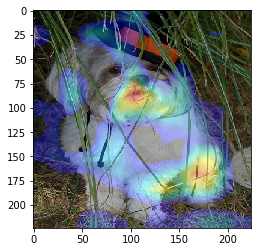

In [10]:
visualize_class_activation_map(model_path=model_path, 
                                   original_img=get_image(X_test, names, name), 
                                   output_path='poet0.jpg', inv_class_map=inv_class_map, thresh=0.1)

predictions [[1.8949690e-07 1.5866827e-07 2.0336211e-02 7.6943087e-07 1.7504754e-03
  9.7782499e-01 2.2903184e-09 8.6866421e-05 3.5549107e-07 7.1870121e-10]]
class weights: (512, 10)
cow*


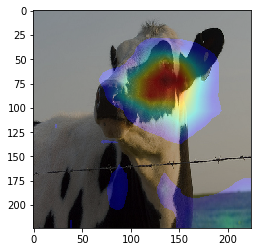

In [11]:
visualize_class_activation_map(model_path=model_path, 
                                   original_img=get_class(X_test, y_test, 'cow')[10], 
                                   output_path='poet0.jpg', inv_class_map=inv_class_map, thresh=0.1)